In [7]:
%matplotlib inline

Using cache found in /home/mark/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-7-25 Python-3.8.10 torch-2.3.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Loading image from: pel_imgs/cat_donskoy.jpg
Image loaded successfully: (420, 640, 3)
Inference results: image 1/1: 420x640 1 person, 1 cat
Speed: 2.1ms pre-process, 97.8ms inference, 0.9ms NMS per image at shape (1, 3, 448, 640)


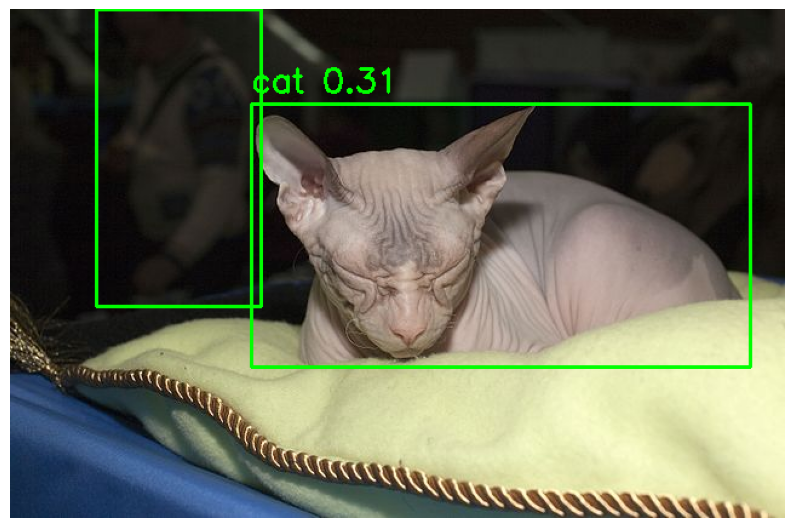

In [12]:
import torch
import cv2
import matplotlib.pyplot as plt

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', source='github')

def run_yolo(image_path):
    print(f"Loading image from: {image_path}")
    
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image from path {image_path}")
        return
    
    print(f"Image loaded successfully: {img.shape}")

    # Convert image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Perform inference
    results = model(img_rgb)
    print(f"Inference results: {results}")

    # Draw bounding boxes on the image
    for bbox in results.xyxy[0].numpy():
        x1, y1, x2, y2, conf, cls = bbox
        cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        label = f"{model.names[int(cls)]} {conf:.2f}"
        cv2.putText(img_rgb, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the image using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Test the function
image_path = 'pel_imgs/cat_donskoy.jpg'
run_yolo(image_path)

In [14]:
import torch
import cv2
import matplotlib.pyplot as plt
import os

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', source='github')

def run_yolo_on_directory(input_dir, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # List all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(input_dir, filename)
            print(f"Processing image: {image_path}")

            # Load image
            img = cv2.imread(image_path)
            if img is None:
                print(f"Error: Could not load image from path {image_path}")
                continue

            print(f"Image loaded successfully: {img.shape}")

            # Convert image from BGR to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Perform inference
            results = model(img_rgb)
            print(f"Inference results: {results}")

            # Draw bounding boxes on the image
            for bbox in results.xyxy[0].numpy():
                x1, y1, x2, y2, conf, cls = bbox
                cv2.rectangle(img_rgb, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                label = f"{model.names[int(cls)]} {conf:.2f}"
                cv2.putText(img_rgb, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

            # Convert image back to BGR for saving with OpenCV
            img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
            
            # Save the image with bounding boxes
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, img_bgr)
            print(f"Saved processed image to: {output_path}")

# Specify the input and output directories
input_directory = 'pel_imgs'  # Replace with your input directory
output_directory = 'pel_imgs/results'  # Replace with your output directory

# Run the function
run_yolo_on_directory(input_directory, output_directory)

Using cache found in /home/mark/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-7-25 Python-3.8.10 torch-2.3.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Processing image: pel_imgs/bean_bag.jpg
Image loaded successfully: (480, 640, 3)
Inference results: image 1/1: 480x640 2 persons, 1 couch
Speed: 1.5ms pre-process, 100.9ms inference, 0.8ms NMS per image at shape (1, 3, 480, 640)
Saved processed image to: pel_imgs/results/bean_bag.jpg
Processing image: pel_imgs/bean_bag_2.jpg
Image loaded successfully: (480, 640, 3)
Inference results: image 1/1: 480x640 3 persons, 1 chair
Speed: 2.6ms pre-process, 98.9ms inference, 1.8ms NMS per image at shape (1, 3, 480, 640)
Saved processed image to: pel_imgs/results/bean_bag_2.jpg


In [24]:
import requests
import csv

def get_wikidata_subclasses_and_instances(entity_id):
    """
    Get subclasses and instances of a given entity from Wikidata.

    Parameters:
    - entity_id: The Wikidata ID of the entity (e.g., 'Q35120' for 'cat')

    Returns:
    - A list of dictionaries containing the ID, label, and type (subclass or instance) of each related entity
    """
    
    query = f"""
    SELECT ?entity ?entityLabel ?type WHERE {{
      {{
        ?entity wdt:P279* wd:{entity_id} .
        BIND("subclass" AS ?type)
      }}
      UNION
      {{
        ?entity wdt:P31* wd:{entity_id} .
        BIND("instance" AS ?type)
      }}
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    """
    
    url = 'https://query.wikidata.org/sparql'
    headers = {
        'User-Agent': 'MyWikidataScript/1.0 (your_email@example.com)'
    }
    response = requests.get(url, headers=headers, params={'query': query, 'format': 'json'})
    
    if response.status_code == 200:
        data = response.json()
        results = data['results']['bindings']
        entities = [{'id': result['entity']['value'].split('/')[-1], 
                     'label': result['entityLabel']['value'],
                     'type': result['type']['value']} for result in results]
        return entities
    else:
        raise Exception(f"Query failed with status code {response.status_code}")

def save_to_csv(entities, entity_id):
    """
    Save the results to a CSV file named after the entity_id.

    Parameters:
    - entities: List of dictionaries containing the ID, label, and type of each related entity
    - entity_id: The Wikidata ID of the entity
    """
    filename = f"{entity_id}.csv"
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['id', 'label', 'type'])
        writer.writeheader()
        for entity in entities:
            writer.writerow(entity)
    print(f"Results saved to {filename}")

# Example usage
property_dict = {'magnitude' : 'Q2091629',
                 'size' : 'Q322481',
                 'relative_quantity' : 'Q100195948',
                 'color' : 'Q1075',
                 'object_form' : 'Q207961',
                 'material' : 'Q214609'}


for key, value in property_dict.items():
    entities = get_wikidata_subclasses_and_instances(value)
    save_to_csv(entities, key)


Results saved to magnitude.csv
Results saved to size.csv
Results saved to relative_quantity.csv
Results saved to color.csv
Results saved to object_form.csv


JSONDecodeError: Expecting ',' delimiter: line 1301161 column 2 (char 32145288)

In [26]:
import requests
import csv
import time

def get_wikidata_subclasses_and_instances(entity_id, max_retries=3):
    """
    Get subclasses and instances of a given entity from Wikidata.

    Parameters:
    - entity_id: The Wikidata ID of the entity (e.g., 'Q35120' for 'cat')
    - max_retries: The maximum number of retries for the request

    Returns:
    - A list of dictionaries containing the ID, label, and type (subclass or instance) of each related entity
    """
    
    query = f"""
    SELECT ?entity ?entityLabel ?type WHERE {{
      {{
        ?entity wdt:P279 wd:{entity_id} .
        BIND("subclass" AS ?type)
      }}
      UNION
      {{
        ?entity wdt:P31 wd:{entity_id} .
        BIND("instance" AS ?type)
      }}
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
    }}
    """
    
    url = 'https://query.wikidata.org/sparql'
    headers = {
        'User-Agent': 'MyWikidataScript/1.0 (your_email@example.com)'
    }
    
    retries = 0
    while retries < max_retries:
        try:
            response = requests.get(url, headers=headers, params={'query': query, 'format': 'json'})
            response.raise_for_status()  # Check for HTTP errors
            data = response.json()
            results = data['results']['bindings']
            entities = [{'id': result['entity']['value'].split('/')[-1], 
                         'label': result['entityLabel']['value'],
                         'type': result['type']['value']} for result in results]
            return entities
        except requests.exceptions.HTTPError as http_err:
            print(f"HTTP error occurred: {http_err}")
        except requests.exceptions.RequestException as req_err:
            print(f"Request error occurred: {req_err}")
        except ValueError as json_err:
            print(f"JSON decode error: {json_err}")
            print("Raw response content:", response.content)
        
        retries += 1
        print(f"Retrying... ({retries}/{max_retries})")
        time.sleep(2)  # Wait before retrying
    
    raise Exception(f"Failed to retrieve data after {max_retries} attempts")

def save_to_csv(entities, entity_id):
    """
    Save the results to a CSV file named after the entity_id.

    Parameters:
    - entities: List of dictionaries containing the ID, label, and type of each related entity
    - entity_id: The Wikidata ID of the entity
    """
    filename = f"{entity_id}.csv"
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['id', 'label', 'type'])
        writer.writeheader()
        for entity in entities:
            writer.writerow(entity)
    print(f"Results saved to {filename}")

# Example usage
property_dict = {'magnitude' : 'Q2091629',
                 'size' : 'Q322481',
                 'relative_quantity' : 'Q100195948',
                 'color' : 'Q1075',
                 'object_form' : 'Q207961',
                 'material' : 'Q214609',
                 'pattern' : 'Q45057822',
                 'texture' : 'Q114817',
                 'transparency' : 'Q487623'}


for key, value in property_dict.items():
    entities = get_wikidata_subclasses_and_instances(value)
    save_to_csv(entities, key)

Results saved to magnitude.csv
Results saved to size.csv
Results saved to relative_quantity.csv
Results saved to color.csv
Results saved to object_form.csv
Results saved to material.csv
Results saved to pattern.csv
Results saved to texture.csv
Results saved to transparency.csv


In [27]:
import os
import csv

def load_wikidata5m_entities(filepath):
    """
    Load entities from wikidata5m_entity.txt into a set for quick lookup.

    Parameters:
    - filepath: Path to wikidata5m_entity.txt file

    Returns:
    - A set containing all entity IDs from the file
    """
    entities = set()
    print(f"Loading entities from {filepath}...")
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            for line in file:
                entity_id = line.split('\t')[0]
                entities.add(entity_id)
        print(f"Loaded {len(entities)} entities from Wikidata5M.")
    except Exception as e:
        print(f"Error loading entities from {filepath}: {e}")
    return entities

def process_csv_files(folder_path, wikidata5m_filepath):
    """
    Process all CSV files in the given folder and save matches in new CSV files.

    Parameters:
    - folder_path: Path to the folder containing CSV files
    - wikidata5m_filepath: Path to wikidata5m_entity.txt file
    """
    # Load Wikidata5M entities
    wikidata5m_entities = load_wikidata5m_entities(wikidata5m_filepath)

    # Process each CSV file in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            input_filepath = os.path.join(folder_path, filename)
            output_filepath = os.path.join(folder_path, filename.replace('.csv', '_wikidata5m.csv'))

            print(f"Processing file: {input_filepath}")

            try:
                with open(input_filepath, 'r', encoding='utf-8') as infile, \
                     open(output_filepath, 'w', newline='', encoding='utf-8') as outfile:
                    
                    reader = csv.DictReader(infile)
                    writer = csv.DictWriter(outfile, fieldnames=reader.fieldnames)
                    writer.writeheader()
                    
                    match_count = 0
                    total_count = 0

                    for row in reader:
                        total_count += 1
                        if row['id'] in wikidata5m_entities:
                            writer.writerow(row)
                            match_count += 1

                    print(f"Processed {total_count} rows, found {match_count} matches.")
            except Exception as e:
                print(f"Error processing file {input_filepath}: {e}")

            print(f"Matches saved to {output_filepath}")

# Example usage
folder_path = '/home/mark/kai_ws/src/locobot_development/pel_ros/src/test'  # Replace with the path to your folder containing CSV files
wikidata5m_filepath = '/home/mark/kai_ws/src/locobot_development/wikidata5m/wikidata5m_alias/wikidata5m_entity.txt'  # Replace with the path to wikidata5m_entity.txt

process_csv_files(folder_path, wikidata5m_filepath)


Loading entities from /home/mark/kai_ws/src/locobot_development/wikidata5m/wikidata5m_alias/wikidata5m_entity.txt...
Loaded 4813491 entities from Wikidata5M.
Processing file: /home/mark/kai_ws/src/locobot_development/pel_ros/src/test/color.csv
Processed 776 rows, found 167 matches.
Matches saved to /home/mark/kai_ws/src/locobot_development/pel_ros/src/test/color_wikidata5m.csv
Processing file: /home/mark/kai_ws/src/locobot_development/pel_ros/src/test/relative_quantity.csv
Processed 34 rows, found 4 matches.
Matches saved to /home/mark/kai_ws/src/locobot_development/pel_ros/src/test/relative_quantity_wikidata5m.csv
Processing file: /home/mark/kai_ws/src/locobot_development/pel_ros/src/test/pattern.csv
Processed 12 rows, found 6 matches.
Matches saved to /home/mark/kai_ws/src/locobot_development/pel_ros/src/test/pattern_wikidata5m.csv
Processing file: /home/mark/kai_ws/src/locobot_development/pel_ros/src/test/texture.csv
Processed 8 rows, found 0 matches.
Matches saved to /home/mark/kai

Using cache found in /home/mark/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-7-25 Python-3.8.10 torch-2.3.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


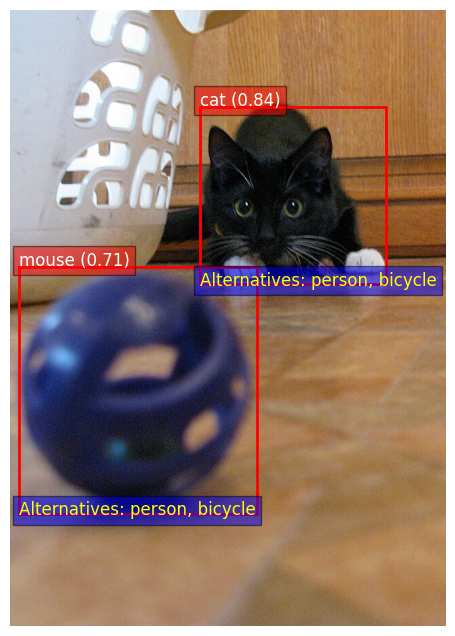

In [31]:
import torch
from matplotlib import pyplot as plt
import cv2
from PIL import Image
import numpy as np

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Function to run YOLO on an image and display results
def run_yolo(image_path):
    # Load image
    img = Image.open(image_path)
    
    # Run YOLO
    results = model(img)

    # Extract detections
    detections = results.xyxy[0].cpu().numpy()
    labels, confidences = results.names, results.xyxy[0][:, -2].cpu().numpy()
    
    # Display the image with detections
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(np.array(img))
    
    for det in detections:
        x1, y1, x2, y2, conf, cls = det
        label = labels[int(cls)]
        top3 = np.argsort(confidences)[::-1][:3]
        alternatives = [labels[i] for i in top3 if i != int(cls)]
        
        # Draw bounding box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        
        # Display label and alternatives
        ax.text(x1, y1 - 2, f'{label} ({conf:.2f})', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))
        ax.text(x1, y2 + 2, f'Alternatives: {", ".join(alternatives[:3])}', fontsize=12, color='yellow', bbox=dict(facecolor='blue', alpha=0.5))
    
    plt.axis('off')
    plt.show()

# Example usage
run_yolo('pel_imgs/cat_kitten.jpg')


Using cache found in /home/mark/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-7-25 Python-3.8.10 torch-2.3.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


[[      278.5       142.4      552.89      402.85     0.83587          15]
 [     12.187       377.8      362.28       740.9     0.70815          64]]


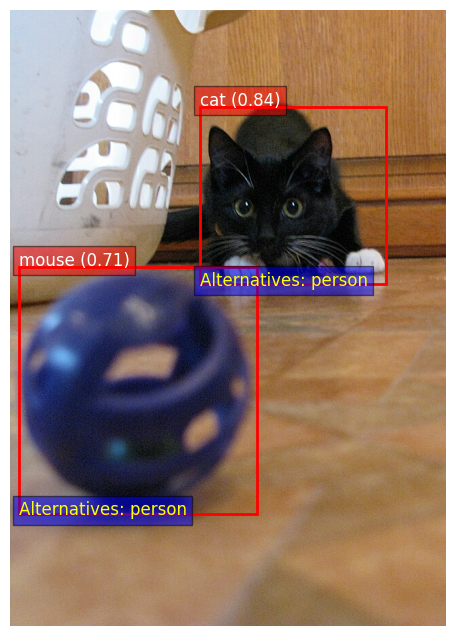

In [44]:
import torch
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Function to run YOLO on an image and display results
def run_yolo(image_path):
    # Load image
    img = Image.open(image_path)
    
    # Run YOLO
    results = model(img)

    # Extract detections
    detections = results.xyxy[0].cpu().numpy()
    labels = results.names
    all_scores = results.pred[0][:, 5:].cpu().numpy()
    # Display the image with detections
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ax.imshow(np.array(img))
    
    for det, scores in zip(detections, all_scores):

        x1, y1, x2, y2, conf, cls = det
        label = labels[int(cls)]

        # Sort scores to get top 3 alternatives excluding the detected class
        #top3_indices = np.argsort(scores)[::-1]
        top3_indices = np.argsort(scores)
        top3_labels = [labels[i] for i in top3_indices if i != int(cls)][:3]
        # Draw bounding box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        
        # Display label and alternatives
        ax.text(x1, y1 - 2, f'{label} ({conf:.2f})', fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))
        ax.text(x1, y2 + 2, f'Alternatives: {", ".join(top3_labels)}', fontsize=12, color='yellow', bbox=dict(facecolor='blue', alpha=0.5))
    
    plt.axis('off')
    plt.show()

# Example usage
run_yolo('pel_imgs/cat_kitten.jpg')
